## This is a script just to test making an ensemble model from a bunch of output code from the base models

In [1]:
import sklearn
import pandas as pd
import numpy
import pickle
import matplotlib.pyplot as plt
print(sklearn.__version__)

1.7.1


In [2]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegressionCV
from sklearn import linear_model
from sklearn import svm
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.calibration import CalibrationDisplay

# Step 1: Import Base Model Outputs & Clean Up

In [3]:
dipoff_df = pd.read_csv("~/zebrafish_output/CRISPR_DIPOFF_output.csv")
net_df = pd.read_csv("~/zebrafish_output/CRISPR_net_output.csv")
pi_df = pd.read_csv("~/zebrafish_output/picrispr_output.csv")
mastermerged_df = pd.read_csv("~/zebrafish_output/master_merged.csv")

In [4]:
dipoff_df[:6]

,sgRNA,targetDNA,predictions,probabilities
0,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,0,2.540000e-24
1,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,0,1.980000e-09
2,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,0,8.220000e-07
3,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,0,1.890000e-13
4,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,0,1.570000e-15
5,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,0,1.370000e-25


In [5]:
dipoff_df = dipoff_df[dipoff_df.duplicated(subset=['sgRNA', 'targetDNA'], keep='first') == False]
len(dipoff_df)

3132

In [6]:
net_df[:6]

,on_seq,off_seq,CRISPR_Net_score
0,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,3.971996e-03
1,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,2.682913e-07
2,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,1.574114e-02
3,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,2.108021e-01
4,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,1.882851e-01
5,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,3.368126e-04


In [7]:
net_df = net_df[net_df.duplicated(subset=['on_seq', 'off_seq'], keep='first') == False]
len(net_df)

3132

In [8]:
pi_df[:6]

,target_sequence,grna_target_sequence,piCRISPR prediction
0,TGATTGGATAAGAGCTACTAGGC,GGAATGGATGAGAGCTACAAGGG,0.999992
1,CTAGTGGAGCACGGTGATGGCGG,CGCGTGGAGCACGGCGAGGAGGG,0.999991
2,TTAGGAGCCCCTGGGCCTCCTGG,TGGGAAGCTCCTGGGCCTTCAGG,0.999999
3,CGGGAGACTCCTGGAACTTCTGG,TGGGAAGCTCCTGGGCCTTCAGG,1.000000
4,CGGGAGACTCCTGGAACTTCCGG,TGGGAAGCTCCTGGGCCTTCAGG,1.000000
5,TGTGTATGTCCTGGACCTCCAGG,TGGGAAGCTCCTGGGCCTTCAGG,0.999999


In [9]:
pi_df = pi_df[pi_df.duplicated(subset=['target_sequence','grna_target_sequence'], keep='first') == False]
len(pi_df)

3132

In [10]:
mastermerged_df[:6]

,Accession,Name,WindowSequence,OffTargetSequence,Cell,Targetsite,TargetSequence,Position.Pvalue,Narrow.Pvalue,Position.Control.Pvalue,Narrow.Control.Pvalue,Cleavage,gene,sgRNA_withPAM,cfd_score
0,ERR5961117,10:19095356-19095379,TTTCTCTCTGCCTAGTAGCTCTTATCCAATCACA,TGATTGGATAAGAGCTACTAGGC,si:dkey-191g9.7_grna2,ERR5961117,GGAATGGATGAGAGCTACAAGGG,0.000000,0.000000,0.004312,0.004326,True,NaN,NaN,NaN
1,ERR5961135,5:46534805-46534828,atcttgccgccatcaccgtgctccactagggt,CTAGTGGAGCACGGTGATGGCGG,pdzk1_grna1,ERR5961135,CGCGTGGAGCACGGCGAGGAGGG,0.000000,0.000000,0.008081,0.008115,True,NaN,NaN,NaN
2,ERR5961098,12:37496976-37496999,CCATATCGTGAGATGAATGGCTCACCAGGAGGCCCAGGGGCTCCTA...,TTAGGAGCCCCTGGGCCTCCTGG,arhgap11a_grna2,ERR5961098,TGGGAAGCTCCTGGGCCTTCAGG,0.000013,0.000041,0.169973,0.170428,True,NaN,NaN,NaN
3,ERR5961098,12:35110599-35110622,gtcattccagaaatccaaagtctcccagaagttccaggagtctccc...,CGGGAGACTCCTGGAACTTCTGG,arhgap11a_grna2,ERR5961098,TGGGAAGCTCCTGGGCCTTCAGG,0.002998,0.006385,0.169973,0.170428,True,NaN,NaN,NaN
4,ERR5961098,12:15160501-15160524,ATAAAGGcagacatcccaagtctcccggaagttccaggagtctccc...,CGGGAGACTCCTGGAACTTCCGG,arhgap11a_grna2,ERR5961098,TGGGAAGCTCCTGGGCCTTCAGG,0.002998,0.006385,0.169973,0.170428,True,NaN,NaN,NaN
5,ERR5961098,11:30034636-30034659,gttaacccaacgctcaactcccaacctggaggtccaggacatacac...,TGTGTATGTCCTGGACCTCCAGG,arhgap11a_grna2,ERR5961098,TGGGAAGCTCCTGGGCCTTCAGG,0.001880,0.004263,0.169973,0.170428,True,NaN,NaN,NaN


In [11]:
len(mastermerged_df)

3353

# Step 2: Combine Dataframes & Transform As Needed

In [12]:
combined_df = dipoff_df
combined_df = combined_df.rename(columns = {'predictions': 'dipoff_predictions', 'probabilities': 'dipoff_probabilities'})
combined_df[:6]

,sgRNA,targetDNA,dipoff_predictions,dipoff_probabilities
0,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,0,2.540000e-24
1,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,0,1.980000e-09
2,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,0,8.220000e-07
3,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,0,1.890000e-13
4,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,0,1.570000e-15
5,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,0,1.370000e-25


In [13]:
len(combined_df)

3132

In [14]:
combined_df = combined_df.merge(net_df, how='inner', left_on=['sgRNA', 'targetDNA'], right_on=['on_seq', 'off_seq'])
combined_df[:6]

,sgRNA,targetDNA,dipoff_predictions,dipoff_probabilities,on_seq,off_seq,CRISPR_Net_score
0,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,0,2.540000e-24,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,3.971996e-03
1,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,0,1.980000e-09,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,2.682913e-07
2,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,0,8.220000e-07,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,1.574114e-02
3,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,0,1.890000e-13,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,2.108021e-01
4,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,0,1.570000e-15,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,1.882851e-01
5,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,0,1.370000e-25,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,3.368126e-04


In [15]:
len(combined_df)

3132

In [16]:
combined_df = combined_df.drop('on_seq', axis=1)
combined_df = combined_df.drop('off_seq', axis=1)
combined_df[:6]

,sgRNA,targetDNA,dipoff_predictions,dipoff_probabilities,CRISPR_Net_score
0,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,0,2.540000e-24,3.971996e-03
1,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,0,1.980000e-09,2.682913e-07
2,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,0,8.220000e-07,1.574114e-02
3,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,0,1.890000e-13,2.108021e-01
4,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,0,1.570000e-15,1.882851e-01
5,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,0,1.370000e-25,3.368126e-04


In [17]:
combined_df = combined_df.merge(pi_df, how='inner', left_on=['sgRNA', 'targetDNA'], right_on=['grna_target_sequence', 'target_sequence'])
combined_df[:6]

,sgRNA,targetDNA,dipoff_predictions,dipoff_probabilities,CRISPR_Net_score,target_sequence,grna_target_sequence,piCRISPR prediction
0,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,0,2.540000e-24,3.971996e-03,TGATTGGATAAGAGCTACTAGGC,GGAATGGATGAGAGCTACAAGGG,0.999992
1,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,0,1.980000e-09,2.682913e-07,CTAGTGGAGCACGGTGATGGCGG,CGCGTGGAGCACGGCGAGGAGGG,0.999991
2,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,0,8.220000e-07,1.574114e-02,TTAGGAGCCCCTGGGCCTCCTGG,TGGGAAGCTCCTGGGCCTTCAGG,0.999999
3,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,0,1.890000e-13,2.108021e-01,CGGGAGACTCCTGGAACTTCTGG,TGGGAAGCTCCTGGGCCTTCAGG,1.000000
4,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,0,1.570000e-15,1.882851e-01,CGGGAGACTCCTGGAACTTCCGG,TGGGAAGCTCCTGGGCCTTCAGG,1.000000
5,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,0,1.370000e-25,3.368126e-04,TGTGTATGTCCTGGACCTCCAGG,TGGGAAGCTCCTGGGCCTTCAGG,0.999999


In [18]:
len(combined_df)

3132

In [19]:
combined_df = combined_df.drop('target_sequence', axis=1)
combined_df = combined_df.drop('grna_target_sequence', axis=1)
combined_df[:6]

,sgRNA,targetDNA,dipoff_predictions,dipoff_probabilities,CRISPR_Net_score,piCRISPR prediction
0,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,0,2.540000e-24,3.971996e-03,0.999992
1,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,0,1.980000e-09,2.682913e-07,0.999991
2,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,0,8.220000e-07,1.574114e-02,0.999999
3,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,0,1.890000e-13,2.108021e-01,1.000000
4,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,0,1.570000e-15,1.882851e-01,1.000000
5,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,0,1.370000e-25,3.368126e-04,0.999999


In [20]:
mastermerged_df = mastermerged_df[['OffTargetSequence', 'TargetSequence', 'Cleavage']]
mastermerged_df[:6]

,OffTargetSequence,TargetSequence,Cleavage
0,TGATTGGATAAGAGCTACTAGGC,GGAATGGATGAGAGCTACAAGGG,True
1,CTAGTGGAGCACGGTGATGGCGG,CGCGTGGAGCACGGCGAGGAGGG,True
2,TTAGGAGCCCCTGGGCCTCCTGG,TGGGAAGCTCCTGGGCCTTCAGG,True
3,CGGGAGACTCCTGGAACTTCTGG,TGGGAAGCTCCTGGGCCTTCAGG,True
4,CGGGAGACTCCTGGAACTTCCGG,TGGGAAGCTCCTGGGCCTTCAGG,True
5,TGTGTATGTCCTGGACCTCCAGG,TGGGAAGCTCCTGGGCCTTCAGG,True


In [21]:
combined_df = mastermerged_df.merge(combined_df, how='inner', left_on=['OffTargetSequence', 'TargetSequence'], right_on=['targetDNA', 'sgRNA'])
combined_df[:6]

,OffTargetSequence,TargetSequence,Cleavage,sgRNA,targetDNA,dipoff_predictions,dipoff_probabilities,CRISPR_Net_score,piCRISPR prediction
0,TGATTGGATAAGAGCTACTAGGC,GGAATGGATGAGAGCTACAAGGG,True,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,0,2.540000e-24,3.971996e-03,0.999992
1,CTAGTGGAGCACGGTGATGGCGG,CGCGTGGAGCACGGCGAGGAGGG,True,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,0,1.980000e-09,2.682913e-07,0.999991
2,TTAGGAGCCCCTGGGCCTCCTGG,TGGGAAGCTCCTGGGCCTTCAGG,True,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,0,8.220000e-07,1.574114e-02,0.999999
3,CGGGAGACTCCTGGAACTTCTGG,TGGGAAGCTCCTGGGCCTTCAGG,True,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,0,1.890000e-13,2.108021e-01,1.000000
4,CGGGAGACTCCTGGAACTTCCGG,TGGGAAGCTCCTGGGCCTTCAGG,True,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,0,1.570000e-15,1.882851e-01,1.000000
5,TGTGTATGTCCTGGACCTCCAGG,TGGGAAGCTCCTGGGCCTTCAGG,True,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,0,1.370000e-25,3.368126e-04,0.999999


In [22]:
len(combined_df)

3353

## We lost a few rows there, presumably because they weren't in the master merged csv for some reason

In [23]:
combined_df = combined_df.drop('sgRNA', axis=1)
combined_df = combined_df.drop('targetDNA', axis=1)

In [24]:
combined_df[:20]

,OffTargetSequence,TargetSequence,Cleavage,dipoff_predictions,dipoff_probabilities,CRISPR_Net_score,piCRISPR prediction
0,TGATTGGATAAGAGCTACTAGGC,GGAATGGATGAGAGCTACAAGGG,True,0,2.540000e-24,3.971996e-03,0.999992
1,CTAGTGGAGCACGGTGATGGCGG,CGCGTGGAGCACGGCGAGGAGGG,True,0,1.980000e-09,2.682913e-07,0.999991
2,TTAGGAGCCCCTGGGCCTCCTGG,TGGGAAGCTCCTGGGCCTTCAGG,True,0,8.220000e-07,1.574114e-02,0.999999
3,CGGGAGACTCCTGGAACTTCTGG,TGGGAAGCTCCTGGGCCTTCAGG,True,0,1.890000e-13,2.108021e-01,1.000000
4,CGGGAGACTCCTGGAACTTCCGG,TGGGAAGCTCCTGGGCCTTCAGG,True,0,1.570000e-15,1.882851e-01,1.000000
5,TGTGTATGTCCTGGACCTCCAGG,TGGGAAGCTCCTGGGCCTTCAGG,True,0,1.370000e-25,3.368126e-04,0.999999
6,AGAAAGGCTCCTGGTCCTTCTGG,TGGGAAGCTCCTGGGCCTTCAGG,True,0,1.320000e-11,6.563095e-03,0.999999
7,ATGCCAACTCCTGGGCCTTCAGA,TGGGAAGCTCCTGGGCCTTCAGG,True,0,1.940000e-30,2.222505e-03,1.000000
8,AGGGAGACTCCCGGACCTTCTGG,TGGGAAGCTCCTGGGCCTTCAGG,True,0,3.280000e-12,1.967398e-01,1.000000
9,CTTGTGGAGCAGGGCATGGATGG,CGCGTGGAGCACGGCGAGGAGGG,True,0,8.000000e-12,2.106081e-08,0.999943


In [25]:
combined_df.to_csv('combined_df.csv')

# Step 3: Train Logistic Regression & Voting Models

In [26]:
training_df = combined_df[["dipoff_probabilities", "CRISPR_Net_score", "piCRISPR prediction"]]
training_df[:6]

,dipoff_probabilities,CRISPR_Net_score,piCRISPR prediction
0,2.540000e-24,3.971996e-03,0.999992
1,1.980000e-09,2.682913e-07,0.999991
2,8.220000e-07,1.574114e-02,0.999999
3,1.890000e-13,2.108021e-01,1.000000
4,1.570000e-15,1.882851e-01,1.000000
5,1.370000e-25,3.368126e-04,0.999999


In [27]:
combined_df[["Cleavage"]][:6]

,Cleavage
0,True
1,True
2,True
3,True
4,True
5,True


In [28]:
# here's where the magic happens

# column-vectors from combined_df couldn't be used as the target for training for some reason, so I had to convert it
# except numpy wouldn't convert it with ravel() alone, so I had to use .values first

test_model_log = LogisticRegressionCV().fit(training_df, combined_df[["Cleavage"]].values.ravel())

In [29]:
# just to be sure it saved it right

type(test_model_log)

sklearn.linear_model._logistic.LogisticRegressionCV

In [30]:
# testing its predictions

yhat = test_model_log.predict_proba(training_df[:20])
print(yhat)

[[0.17542969 0.82457031]
 [0.17425112 0.82574888]
 [0.17895881 0.82104119]
 [0.24560153 0.75439847]
 [0.23712188 0.76287812]
 [0.17435067 0.82564933]
 [0.17620188 0.82379812]
 [0.17490969 0.82509031]
 [0.240282   0.759718  ]
 [0.17425154 0.82574846]
 [0.44504992 0.55495008]
 [0.17496825 0.82503175]
 [0.17503673 0.82496327]
 [0.17446167 0.82553833]
 [0.17481846 0.82518154]
 [0.17439871 0.82560129]
 [0.1796048  0.8203952 ]
 [0.17433018 0.82566982]
 [0.1876517  0.8123483 ]
 [0.1763832  0.8236168 ]]


In [31]:
test_model_log.classes_

array([False,  True])

In [32]:
test_model_linear = linear_model.LinearRegression().fit(training_df, combined_df[["Cleavage"]].values.ravel())

In [33]:
type(test_model_linear)

sklearn.linear_model._base.LinearRegression

In [34]:
yhat = test_model_linear.predict(training_df[:20])
print(yhat)

[1.00263021 1.00614965 0.99220089 0.81935654 0.83930895 1.00585055
 1.00033343 1.00417957 0.8318172  1.00615525 0.60517825 1.00400611
 1.0038022  1.00552076 1.00445848 1.00571495 0.99030964 1.00593379
 1.06914462 0.99979841]


In [35]:
# pickle

with open('test_model_log.pkl','wb') as f:
    pickle.dump(test_model_log,f)
    
with open('test_model_linear.pkl','wb') as f:
    pickle.dump(test_model_linear,f)

# Step 4: Visualize Performance

In [36]:
cleavage_array = combined_df[["Cleavage"]].to_numpy()
dipoff_pred_array = training_df[["dipoff_probabilities"]].to_numpy()
net_pred_array = training_df[["CRISPR_Net_score"]].to_numpy()
pi_pred_array = training_df[["piCRISPR prediction"]].to_numpy()
yhat = test_model_log.predict_proba(training_df)
log_pred_df = pd.DataFrame(yhat, columns=['False', 'True'])
print (log_pred_df)
log_pred_array = log_pred_df[["True"]].to_numpy()

         False      True
0     0.175430  0.824570
1     0.174251  0.825749
2     0.178959  0.821041
3     0.245602  0.754398
4     0.237122  0.762878
...        ...       ...
3348  0.622708  0.377292
3349  0.622705  0.377295
3350  0.622705  0.377295
3351  0.622703  0.377297
3352  0.622706  0.377294

[3353 rows x 2 columns]


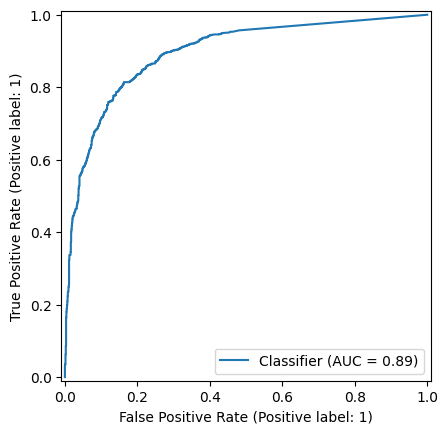

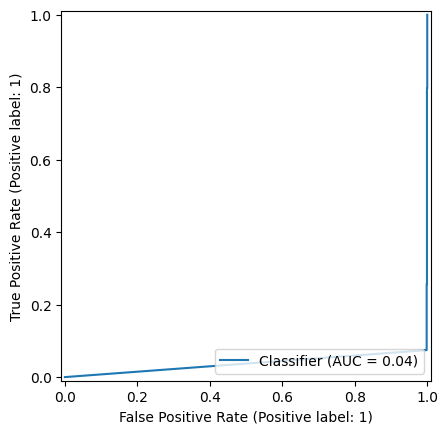

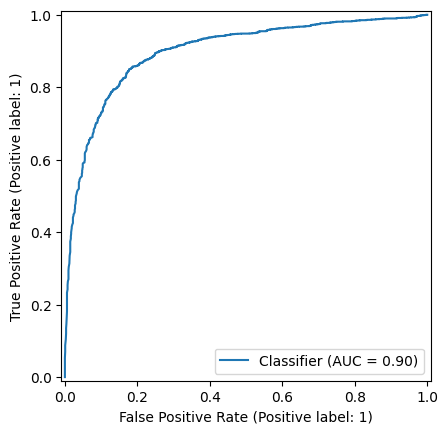

In [37]:
RocCurveDisplay.from_predictions(combined_df[["Cleavage"]], dipoff_pred_array)
RocCurveDisplay.from_predictions(combined_df[["Cleavage"]], net_pred_array)
RocCurveDisplay.from_predictions(combined_df[["Cleavage"]], pi_pred_array)

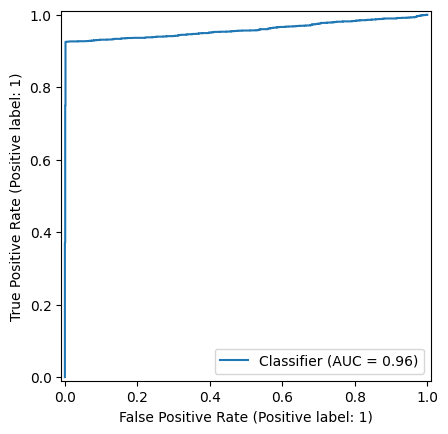

In [38]:
RocCurveDisplay.from_predictions(combined_df[["Cleavage"]], log_pred_array)

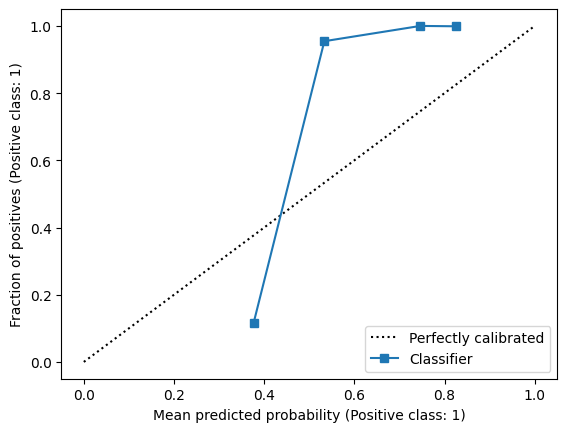

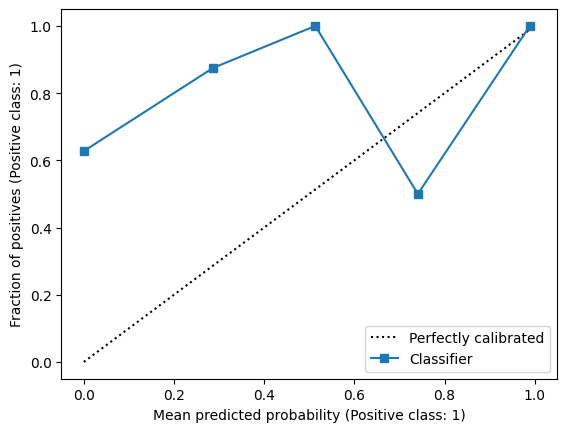

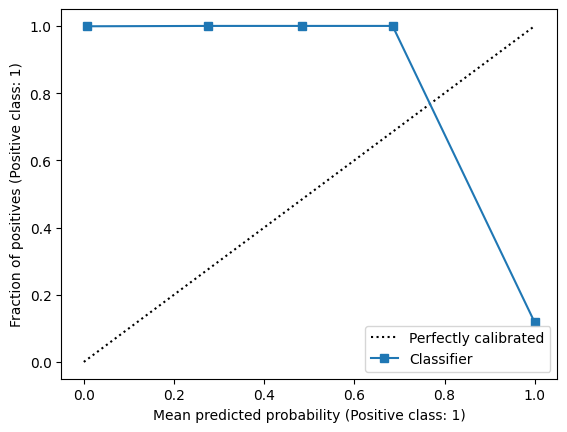

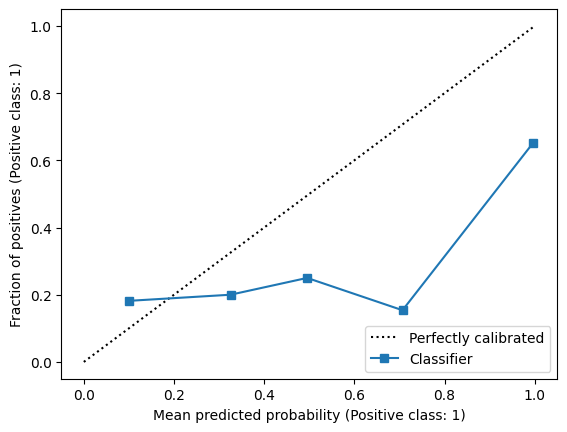

In [39]:
disp = CalibrationDisplay.from_predictions(combined_df[["Cleavage"]], log_pred_array)
disp = CalibrationDisplay.from_predictions(combined_df[["Cleavage"]], dipoff_pred_array)
disp = CalibrationDisplay.from_predictions(combined_df[["Cleavage"]], net_pred_array)
disp = CalibrationDisplay.from_predictions(combined_df[["Cleavage"]], pi_pred_array)
plt.show()

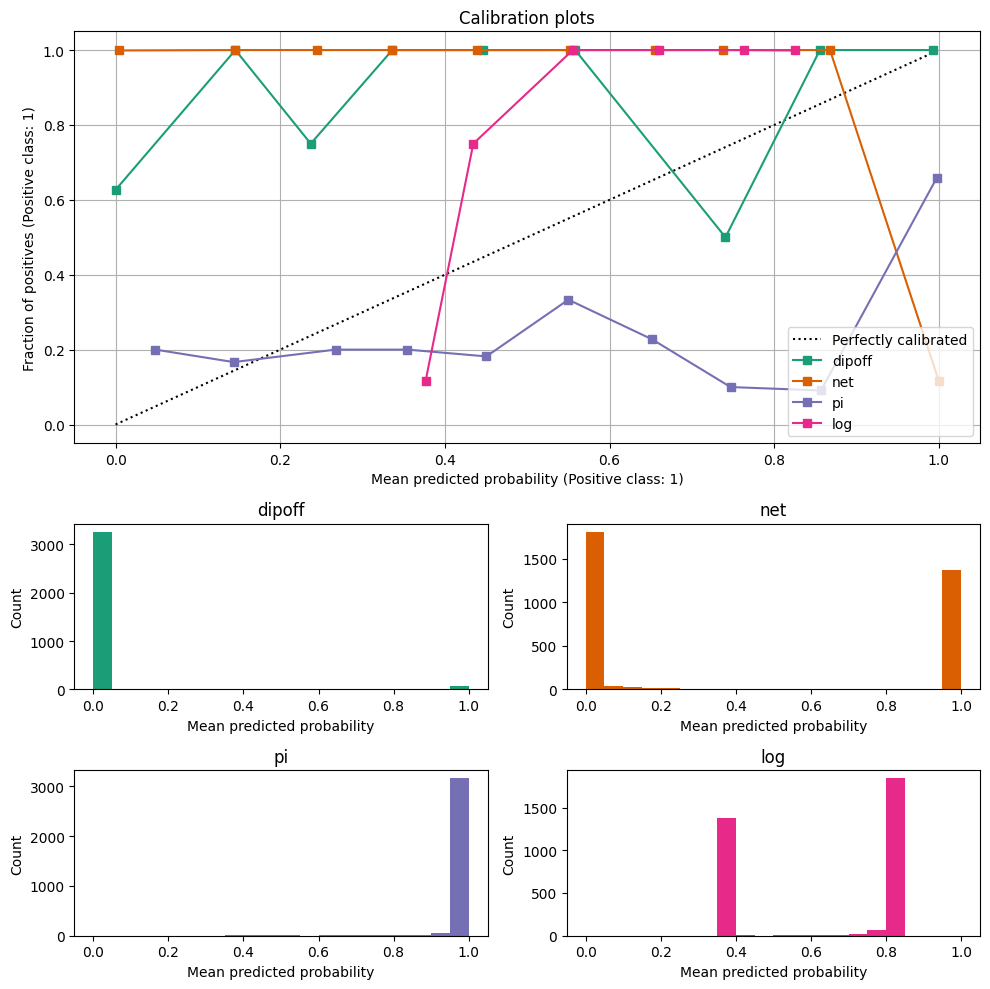

In [40]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

display = CalibrationDisplay.from_predictions(combined_df[["Cleavage"]], dipoff_pred_array, n_bins=10, name="dipoff",
        ax=ax_calibration_curve, color=colors(0))
calibration_displays["dipoff"] = display
display = CalibrationDisplay.from_predictions(combined_df[["Cleavage"]], net_pred_array, n_bins=10, name="net",
        ax=ax_calibration_curve, color=colors(1))
calibration_displays["net"] = display
display = CalibrationDisplay.from_predictions(combined_df[["Cleavage"]], pi_pred_array, n_bins=10, name="pi",
        ax=ax_calibration_curve, color=colors(2))
calibration_displays["pi"] = display
display = CalibrationDisplay.from_predictions(combined_df[["Cleavage"]], log_pred_array, n_bins=10, name="log",
        ax=ax_calibration_curve, color=colors(3))
calibration_displays["log"] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
row, col = grid_positions[0]
ax = fig.add_subplot(gs[row, col])
ax.hist(
        calibration_displays["dipoff"].y_prob,
        range=(0, 1),
        bins=20,
        label="dipoff",
        color=colors(0),)
ax.set(title="dipoff", xlabel="Mean predicted probability", ylabel="Count")

row, col = grid_positions[1]
ax = fig.add_subplot(gs[row, col])
ax.hist(
        calibration_displays["net"].y_prob,
        range=(0, 1),
        bins=20,
        label="net",
        color=colors(1),)
ax.set(title="net", xlabel="Mean predicted probability", ylabel="Count")

row, col = grid_positions[2]
ax = fig.add_subplot(gs[row, col])
ax.hist(
        calibration_displays["pi"].y_prob,
        range=(0, 1),
        bins=20,
        label="pi",
        color=colors(2),)
ax.set(title="pi", xlabel="Mean predicted probability", ylabel="Count")

row, col = grid_positions[3]
ax = fig.add_subplot(gs[row, col])
ax.hist(
        calibration_displays["log"].y_prob,
        range=(0, 1),
        bins=20,
        label="log",
        color=colors(3),)
ax.set(title="log", xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [41]:
yhat = test_model_linear.predict(training_df)
linear_pred_df = pd.DataFrame(yhat)
print (linear_pred_df)
linear_pred_array = linear_pred_df.to_numpy()

             0
0     1.002630
1     1.006150
2     0.992201
3     0.819357
4     0.839309
...        ...
3348  0.120085
3349  0.120061
3350  0.120061
3351  0.120046
3352  0.120071

[3353 rows x 1 columns]


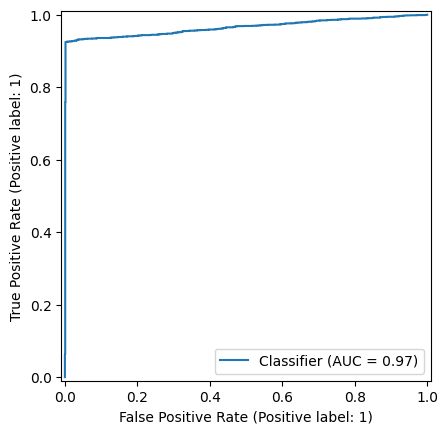

In [42]:
RocCurveDisplay.from_predictions(combined_df[["Cleavage"]], linear_pred_array)

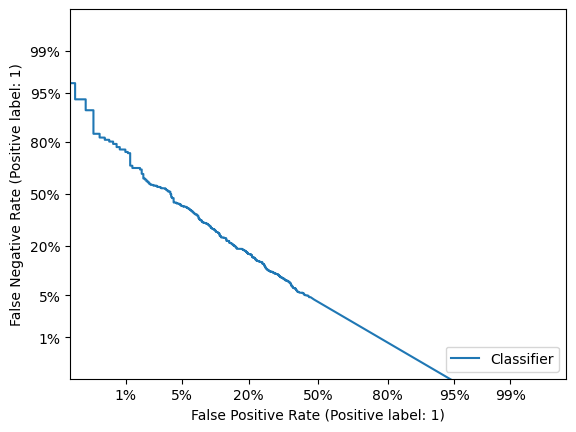

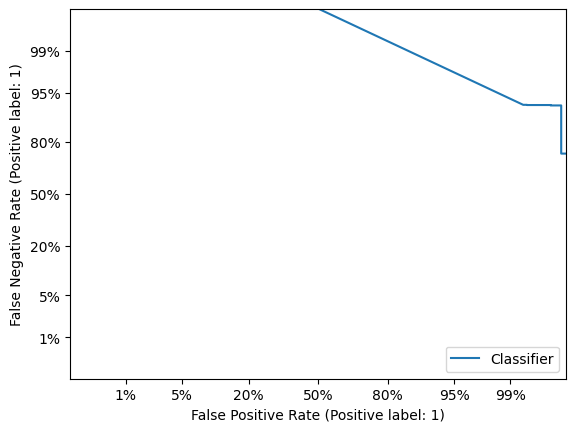

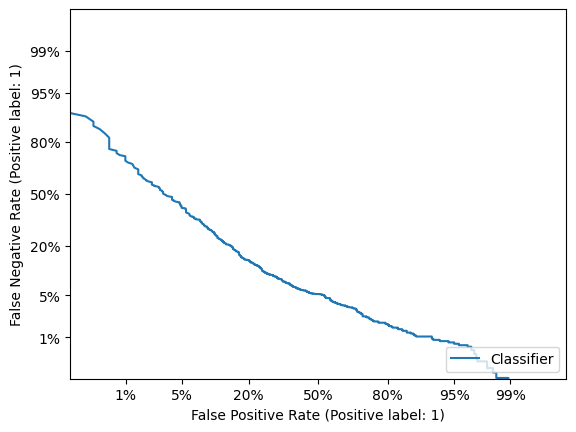

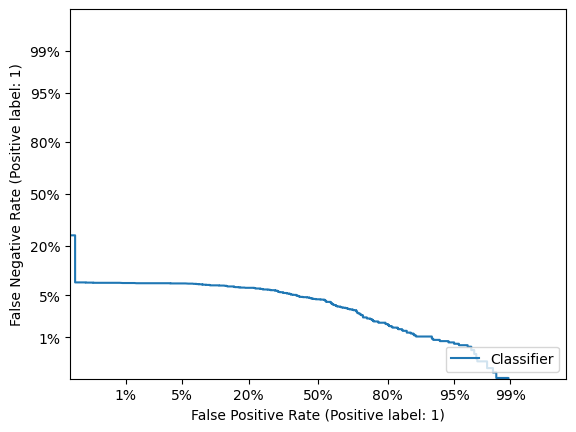

In [43]:
from sklearn.metrics import DetCurveDisplay
DetCurveDisplay.from_predictions(combined_df[["Cleavage"]], dipoff_pred_array)
DetCurveDisplay.from_predictions(combined_df[["Cleavage"]], net_pred_array)
DetCurveDisplay.from_predictions(combined_df[["Cleavage"]], pi_pred_array)
DetCurveDisplay.from_predictions(combined_df[["Cleavage"]], log_pred_array)
plt.show()

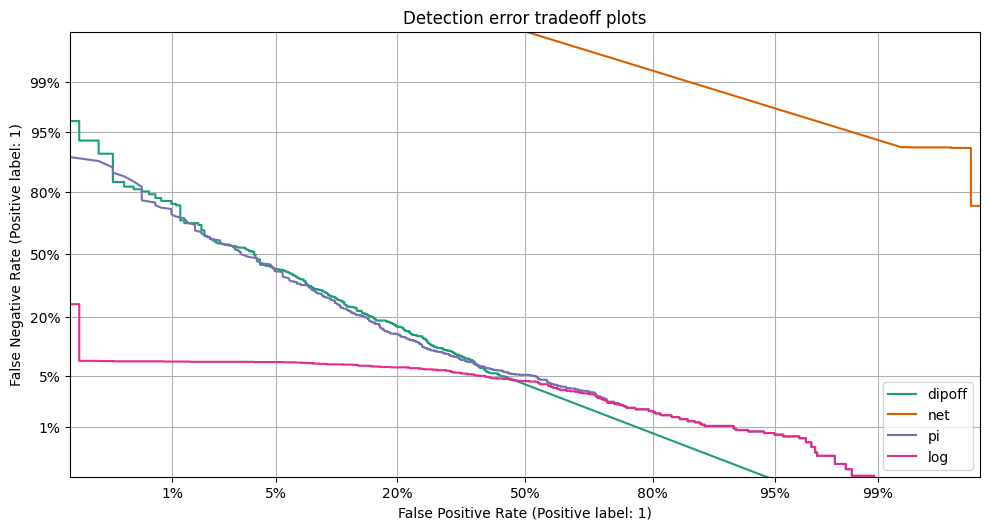

In [44]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

display = DetCurveDisplay.from_predictions(combined_df[["Cleavage"]], dipoff_pred_array, name="dipoff",
        ax=ax_calibration_curve, color=colors(0))
calibration_displays["dipoff"] = display
display = DetCurveDisplay.from_predictions(combined_df[["Cleavage"]], net_pred_array, name="net",
        ax=ax_calibration_curve, color=colors(1))
calibration_displays["net"] = display
display = DetCurveDisplay.from_predictions(combined_df[["Cleavage"]], pi_pred_array, name="pi",
        ax=ax_calibration_curve, color=colors(2))
calibration_displays["pi"] = display
display = DetCurveDisplay.from_predictions(combined_df[["Cleavage"]], log_pred_array, name="log",
        ax=ax_calibration_curve, color=colors(3))
calibration_displays["log"] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Detection error tradeoff plots")

plt.tight_layout()
plt.show()

/home/jsinohui/.local/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/home/jsinohui/.local/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/home/jsinohui/.local/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/home/jsinohui/.local/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


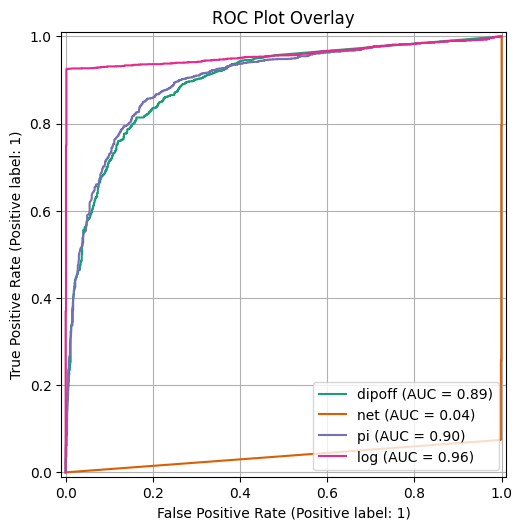

In [47]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

display = RocCurveDisplay.from_predictions(combined_df[["Cleavage"]], dipoff_pred_array, name="dipoff",
        ax=ax_calibration_curve, color=colors(0))
calibration_displays["dipoff"] = display
display = RocCurveDisplay.from_predictions(combined_df[["Cleavage"]], net_pred_array, name="net",
        ax=ax_calibration_curve, color=colors(1))
calibration_displays["net"] = display
display = RocCurveDisplay.from_predictions(combined_df[["Cleavage"]], pi_pred_array, name="pi",
        ax=ax_calibration_curve, color=colors(2))
calibration_displays["pi"] = display
display = RocCurveDisplay.from_predictions(combined_df[["Cleavage"]], log_pred_array, name="log",
        ax=ax_calibration_curve, color=colors(3))
calibration_displays["log"] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("ROC Plot Overlay")

plt.tight_layout()
plt.show()